## Importing libraries and data cleaning
- Analysing movies from recent years (2000-2020)
- Dropping rows with missing values (if any)
- Dissecting the "released" column to obtain release country
- Assigning bins to runtime to help with analysis

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings('ignore')

# Formatters
@ticker.FuncFormatter
def billion_formatter(x, pos):
    return "%.1f Billions" % (x/1E9)

@ticker.FuncFormatter
def million_formatter(x, pos):
    return "%.1f Millions" % (x/1E6)


# Display in float
pd.set_option('display.float_format', lambda x: '%.3f' % x)

CSV_PATH = 'movies.csv'
df = pd.read_csv(CSV_PATH)


# We filter movies after year 2000
df = df[df['year'] >= 2000]
# We drop NaN rows
df = df.dropna()

# helper function to extract release country
def obtainCountry(string):
    idx1 = string.index("(")
    idx2 = string.index(")")
    return string[idx1 + 1: idx2]

df["releaseCountry"] = df["released"].apply(obtainCountry)

# helper function to categorise runtime into bins
def categoriseRuntime(runtime):
    if runtime < 60.0:
        return "< 60"
    elif runtime < 90.0:
        return "60 - 89"
    elif runtime < 120.0:
        return "90 - 119"
    elif runtime < 150.0:
        return "120 - 149"
    elif runtime < 180.0:
        return "150 - 179"
    elif runtime < 210.0:
        return "180 - 209"
    else:
        return ">= 210"

df["duration"] = df["runtime"].apply(categoriseRuntime)

## Analysing the relationship between run-time and other factors to obtain optimal run-time

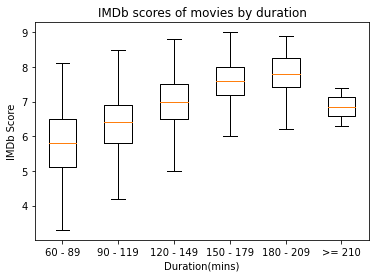

In [16]:
x = ["60 - 89", "90 - 119", "120 - 149", "150 - 179", "180 - 209", ">= 210"]

scores = []
for i in range(len(x)):
    filtered = df[df["duration"] == x[i]]
    scores.append(filtered["score"])

fig, ax = plt.subplots()
ax.set_xticklabels(x)
plt.boxplot(scores, showfliers=False)
plt.title("IMDb scores of movies by duration")
plt.xlabel("Duration(mins)")
plt.ylabel("IMDb Score")
plt.show()

## Determining the best director to engage for the movie

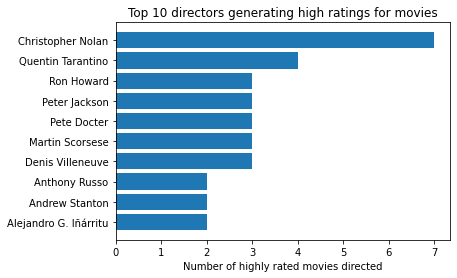

In [ ]:
topscores = df[df["score"] >= 8.0]
top10directors_score = topscores[["director", "score"]].groupby("director").count().reset_index().nlargest(10, "score")
top10directors_score = top10directors_score.rename(columns={"score": "appearances"})
top10directors_score = top10directors_score.sort_values("appearances")

fig, ax = plt.subplots()
ax.barh(top10directors_score["director"], top10directors_score["appearances"])
plt.title("Top 10 directors generating high ratings for movies")
plt.xlabel("Number of highly rated movies directed")
plt.show()

## Determining the best main actor/actress to engage for the movie

- by comparing number of appearances made in movies with IMDb scores >= 8.0
- by comparing number of appearances made in movies directed by Christopher Nolan (Highest ratings director as seen above)

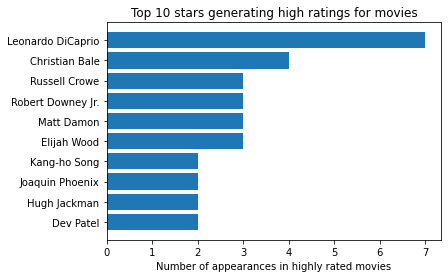

In [18]:
topscores = df[df["score"] >= 8.0]
top10stars_score = topscores[["star", "score"]].groupby("star").count().reset_index().nlargest(10, "score")
top10stars_score = top10stars_score.rename(columns={"score": "appearances"})
top10stars_score = top10stars_score.sort_values("appearances")

fig, ax = plt.subplots()
ax.barh(top10stars_score["star"], top10stars_score["appearances"])
plt.title("Top 10 stars generating high ratings for movies")
plt.xlabel("Number of appearances in highly rated movies")
plt.show()


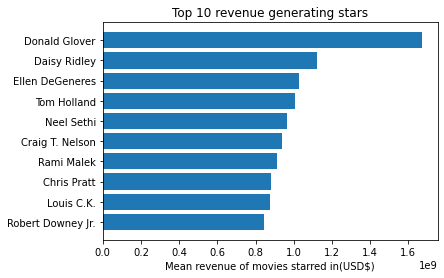

In [19]:
nolan = df[df["director"] == "Christopher Nolan"]
nolan_stars = nolan[["star", "score"]].groupby("star").count().reset_index()
nolan_stars = nolan_stars.rename(columns={"score": "appearances"})
nolan_stars = nolan_stars.sort_values("appearances")

fig, ax = plt.subplots()
plt.pie([x*100 for x in nolan_stars["appearances"]],labels=[x for x in nolan_stars["star"]],autopct='%1.1f%%')
plt.title("Stars starring in Christopher Nolan's movies")
plt.show()

## Determining which country to produce the movie in
- based on mean IMDb ratings

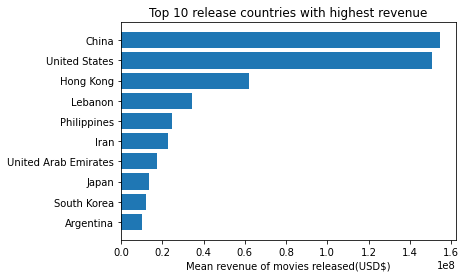

In [22]:

countries_score = df[df.groupby("country")['country'].transform('count')>5]
top10countries_score = countries_score[["country", "score"]].groupby("country").mean().reset_index().nlargest(10, "score")
countries = top10countries_score["country"]
countries_score = countries_score[countries_score.country.isin(countries)]

sb.swarmplot(x="score", y="country", data=countries_score)

## Determining which country to release the movie in
- based on mean IMDb ratings

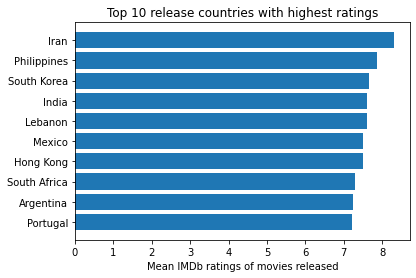

In [23]:
relcountries_score = df[df.groupby("releaseCountry")['releaseCountry'].transform('count')>5]
top10relcountries_score = relcountries_score[["releaseCountry", "score"]].groupby("releaseCountry").mean().reset_index().nlargest(10, "score")
relcountries = top10relcountries_score["releaseCountry"]
relcountries_score = relcountries_score[relcountries_score.releaseCountry.isin(relcountries)]

sb.catplot(x="score", y="releaseCountry", kind="swarm", data=relcountries_score)

##  Analysis of correlation between score of movie and revenue of movie


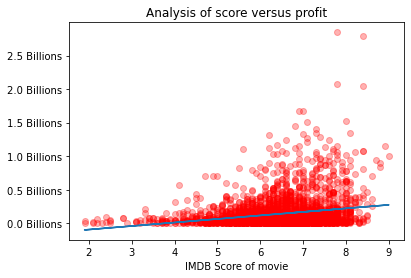

In [24]:
@ticker.FuncFormatter
def billion_formatter(x, pos):
    return "%.1f Billions" % (x/1E9)

score_gross = df[['score','gross']]

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(billion_formatter)
plt.scatter(score_gross['score'],      
            score_gross['gross'],      
            c='r', alpha=0.3)      
plt.title("Analysis of score versus profit")
plt.xlabel("IMDB Score of movie")
m, b = np.polyfit(score_gross['score'],score_gross['gross'], 1)
plt.plot(score_gross['score'], m * score_gross['score'] + b);


## Determining which genre the audience enjoys the most
- based on average revenue
- based on average score

Text(0.5, 0, 'Gross')

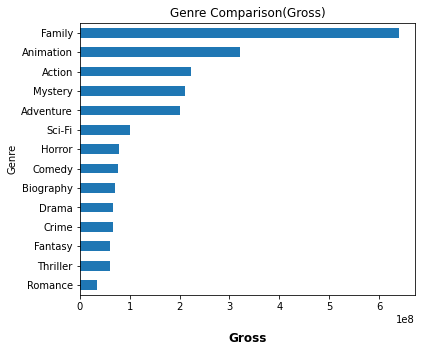

In [25]:
group_by_genre_df = df.groupby('genre')
gross_mean_across_genre = group_by_genre_df['gross'].mean().sort_values()

ax = gross_mean_across_genre.plot(kind='barh', title='Genre Comparison(Gross)', ylabel='Gross',
         xlabel='Genre', figsize=(6, 5));
ax.set_xlabel("Gross", labelpad=20, weight='bold', size=12)


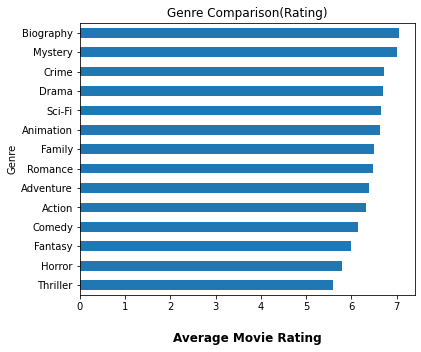

In [26]:
gross_mean_across_genre = group_by_genre_df['score'].mean().sort_values()
ax = gross_mean_across_genre.plot(kind='barh', title='Genre Comparison(Rating)', ylabel='Rating',
         xlabel='Genre', figsize=(6, 5));
ax.set_xlabel("Average Movie Rating", labelpad=20, weight='bold', size=12);


##  Analysis of correlation between budget of movie and score of movie


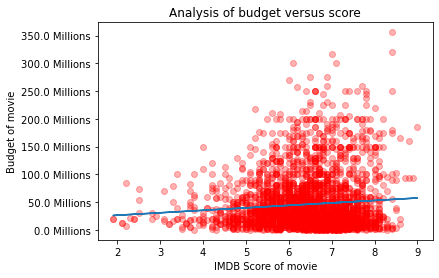

In [27]:
budget_score = df[['score','budget']]
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(million_formatter)

plt.scatter(budget_score['score'],      
            budget_score['budget'],      
            c='r', alpha=0.3)      


plt.title("Analysis of budget versus score")
plt.xlabel("IMDB Score of movie")
plt.ylabel("Budget of movie")

m, b = np.polyfit(budget_score['score'],budget_score['budget'], 1)
plt.plot(budget_score['score'], m * budget_score['score'] + b);


##  Analysis of correlation between number of votes and score of a movie  


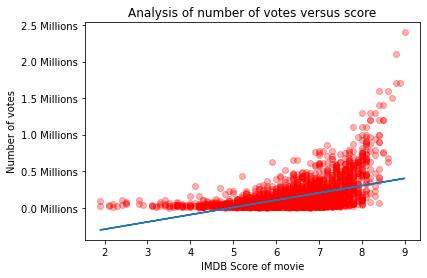

In [28]:

score_votes = df[['score','votes']]

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(million_formatter)

plt.scatter(score_votes['score'],      
            score_votes['votes'],      
            c='r', alpha=0.3)      
plt.title("Analysis of number of votes versus score")
plt.xlabel("IMDB Score of movie")
plt.ylabel("Number of votes")

m, b = np.polyfit(score_votes['score'],score_votes['votes'], 1)
plt.plot(score_votes['score'], m * score_votes['score'] + b);


## Linear Regression
- Dependent Variable: "score"
- Independent Variables: "genre", "runtime"
- omitted the rest due to large number of unique values

In [29]:
import statsmodels.formula.api as smf

model = smf.ols('score ~ genre + duration', data = df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     52.49
Date:                Mon, 11 Apr 2022   Prob (F-statistic):          3.00e-164
Time:                        22:29:08   Log-Likelihood:                -3943.0
No. Observations:                3169   AIC:                             7924.
Df Residuals:                    3150   BIC:                             8039.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 6.75